In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import random

# Initialize program details
n_p = 20
progs = [chr(65 + i) for i in range(n_p)]
p_s = {p: np.random.randint(40, 100, size=6) for p in progs}
p_sal = {p: np.random.randint(5, 10) for p in progs}
p_vers = {p: np.random.randint(5, 10) for p in progs}
p_elg = {p: np.random.randint(50, 90) for p in progs}


u_s = np.random.randint(50, 100, size=6).astype(float)
u_elg = float(np.random.randint(50, 90))  
w_sal = 0.6
w_vers = 0.3
w_elg = 0.1

q_vals = {p: 0.0 for p in progs}
lr = 0.1
gamma = 0.9
f_adj = 0.5
epsilon_threshold = 0.01
top_n = 5


questions_pool = np.random.rand(1000)
asked_questions = []

def ask_qs():
    global asked_questions, u_s
    selected_questions = random.sample(list(questions_pool), 6)
    for weight in selected_questions:
        answer = int(input(f"Answer question (0-5): "))
        answer = max(0, min(answer, 5)) 
        u_s += answer * weight  
    asked_questions.extend(selected_questions)
    return u_s

def update_q_vals():
    epsilon = 0
    for p in progs:
        sim = np.dot(u_s, p_s[p]) / (np.linalg.norm(u_s) * np.linalg.norm(p_s[p]))
        elg_impact = u_elg / p_elg[p]
        r_sal = p_sal[p] * sim
        r_vers = p_vers[p] * sim
        r_elg = elg_impact * 10
        reward = w_sal * r_sal + w_vers * r_vers + w_elg * r_elg
        max_q = max(q_vals.values())
        old_q = q_vals[p]
        q_vals[p] = (1 - lr) * q_vals[p] + lr * (reward + gamma * max_q)
        
    return q_vals, old_q

def get_feedback(rec):
    global progs
    fb = {p: int(input(f"Rate {p} (0-5): ")) for p in rec}
    for p, score in fb.items():
        if score == 0:
            progs.remove(p)
            del q_vals[p]
        else:
            q_vals[p] += f_adj * (score - 2) * 5

max_ep = 10
for ep in range(max_ep):
    u_s = ask_qs()
    q_vals, old_q = update_q_vals()
    epsilon=abs(q_vals-old_q)
    print(q_vals, old_q)
    if len(progs) < top_n:
        break
    
    if epsilon < epsilon_threshold:
        rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
        get_feedback(rec)
        satisfied = input("Satisfied? (yes/no): ").strip().lower()

        if satisfied == 'yes':
            break

if len(progs) >= top_n:
    print("\nFinal Recommendations:")
    rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
    for i, p in enumerate(rec, 1):
        print(f"{i}. {p}")
else:
    print("\nNot enough programs left to recommend. Test ends.")


In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IRT import AdaptiveMIRT
from debugging import OptimizedAdaptiveMIRT
from test import AdaptiveMIRTv2
cur1 = []
cur2 = []
cur3 = []

ImportError: cannot import name 'AdaptiveMIRTv2' from 'test' (c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\test\__init__.py)

In [ ]:
v2 = OptimizedAdaptiveMIRTv2(n_items=1000, select_noise=0.05,n_traits=5, verbose=False)
n_steps = 300
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    item = v2.next_item()
    resp = v2.sim_resp()
    v2.update_theta()

In [43]:
for _ in range(20):
    model = OptimizedAdaptiveMIRT(n_items=1000, select_noise=0.05,n_traits=5, verbose=False)
    n_steps = 300
    for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
        item = model.next_item()
        resp = model.sim_resp()
        model.update_theta()
    cur1.append(model.info_gain)

Running Adaptive Testing: 100%|██████████| 300/300 [00:07<00:00, 38.89it/s]


In [44]:
for _ in range(20):
    vanila = AdaptiveMIRT(n_items=1000, select_noise=0.05,n_traits=5, verbose=False)
    n_steps = 300
    for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
        item = vanila.next_item()
        resp = vanila.sim_resp()
        vanila.update_theta()
    cur2.append(vanila.info_gain)

Running Adaptive Testing: 100%|██████████| 300/300 [00:09<00:00, 33.31it/s]


In [66]:
len(cur1[40:][0])

300

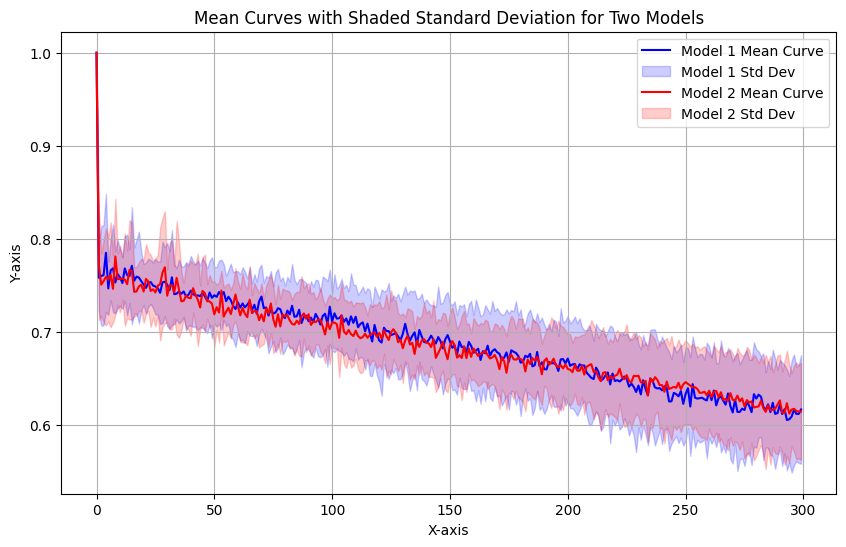

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for two models: 20 curves each of length 100 (simulated data)
n_curves = 20
n_points = 300
data_model_1 = np.array(cur1[40:])  # Replace with curves from Model 1
data_model_2 = np.array(cur2[40:])  # Replace with curves from Model 2

# Calculate the mean and standard deviation for both models
mean_curve_1 = np.mean(data_model_1, axis=0)
std_curve_1 = np.std(data_model_1, axis=0)

mean_curve_2 = np.mean(data_model_2, axis=0)
std_curve_2 = np.std(data_model_2, axis=0)

# Plotting the mean curves with shaded standard deviation intervals
x = np.arange(n_points)

plt.figure(figsize=(10, 6))
plt.plot(x, mean_curve_1, label='Model 1 Mean Curve', color='blue')
plt.fill_between(x, mean_curve_1 - std_curve_1, mean_curve_1 + std_curve_1, color='blue', alpha=0.2, label='Model 1 Std Dev')

plt.plot(x, mean_curve_2, label='Model 2 Mean Curve', color='red')
plt.fill_between(x, mean_curve_2 - std_curve_2, mean_curve_2 + std_curve_2, color='red', alpha=0.2, label='Model 2 Std Dev')

plt.title("Mean Curves with Shaded Standard Deviation for Two Models")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
vanila = AdaptiveMIRT(n_items=1000, select_noise=0.05,n_traits=5, verbose=False)
n_steps = 100
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    item = vanila.next_item()
    resp = vanila.sim_resp()
    vanila.update_theta()

Running Adaptive Testing: 100%|██████████| 100/100 [00:01<00:00, 81.76it/s]


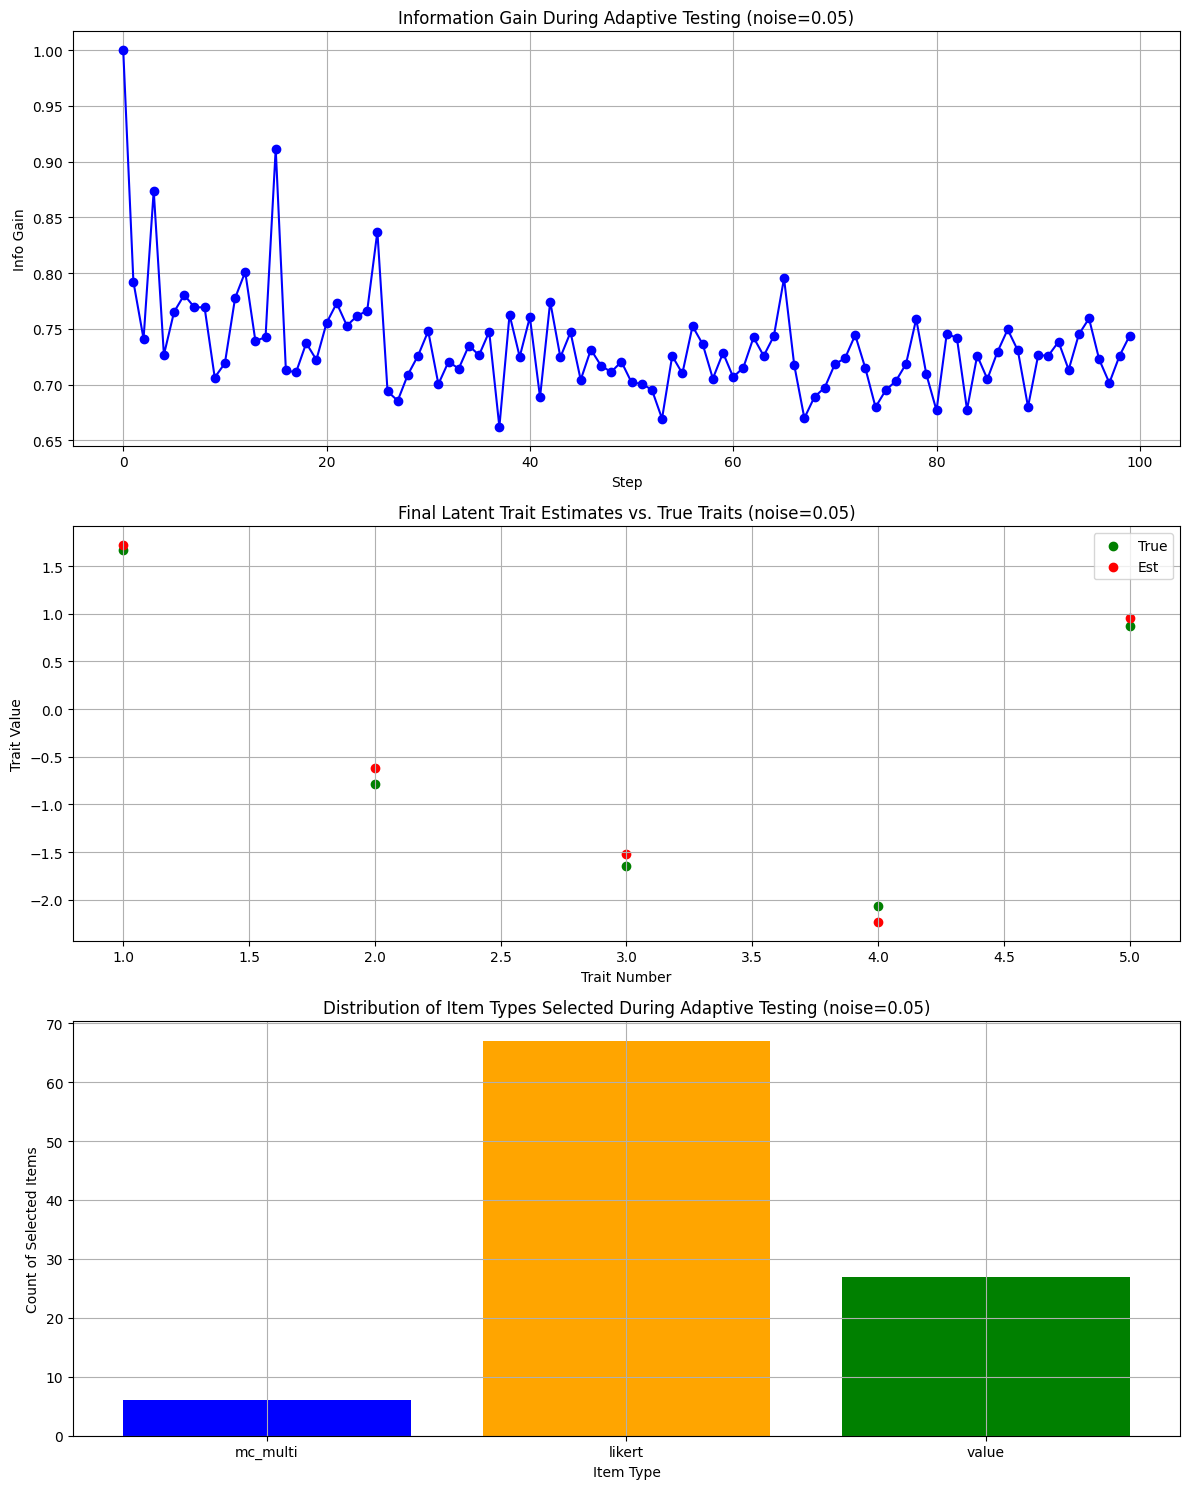

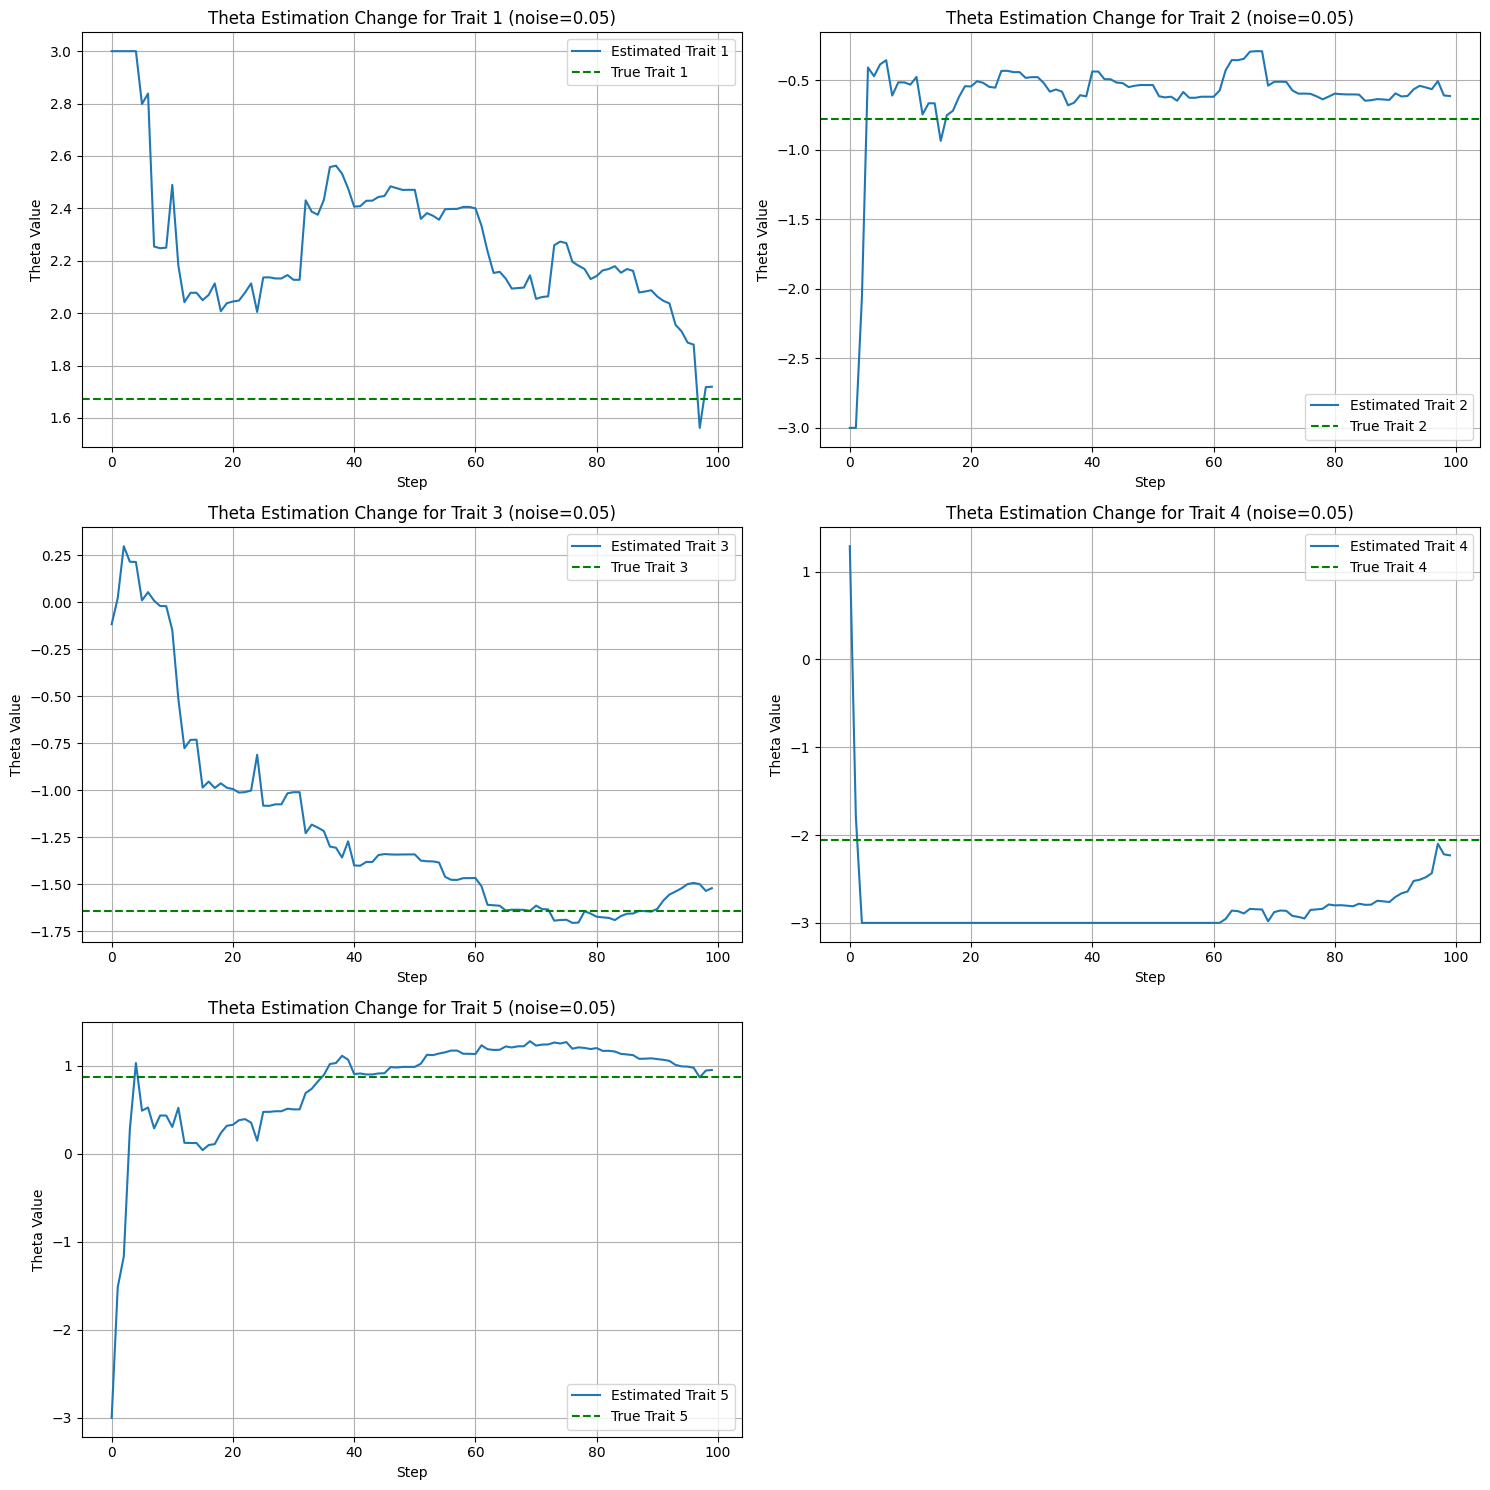

In [41]:
model.plot_results(save_fig=False)

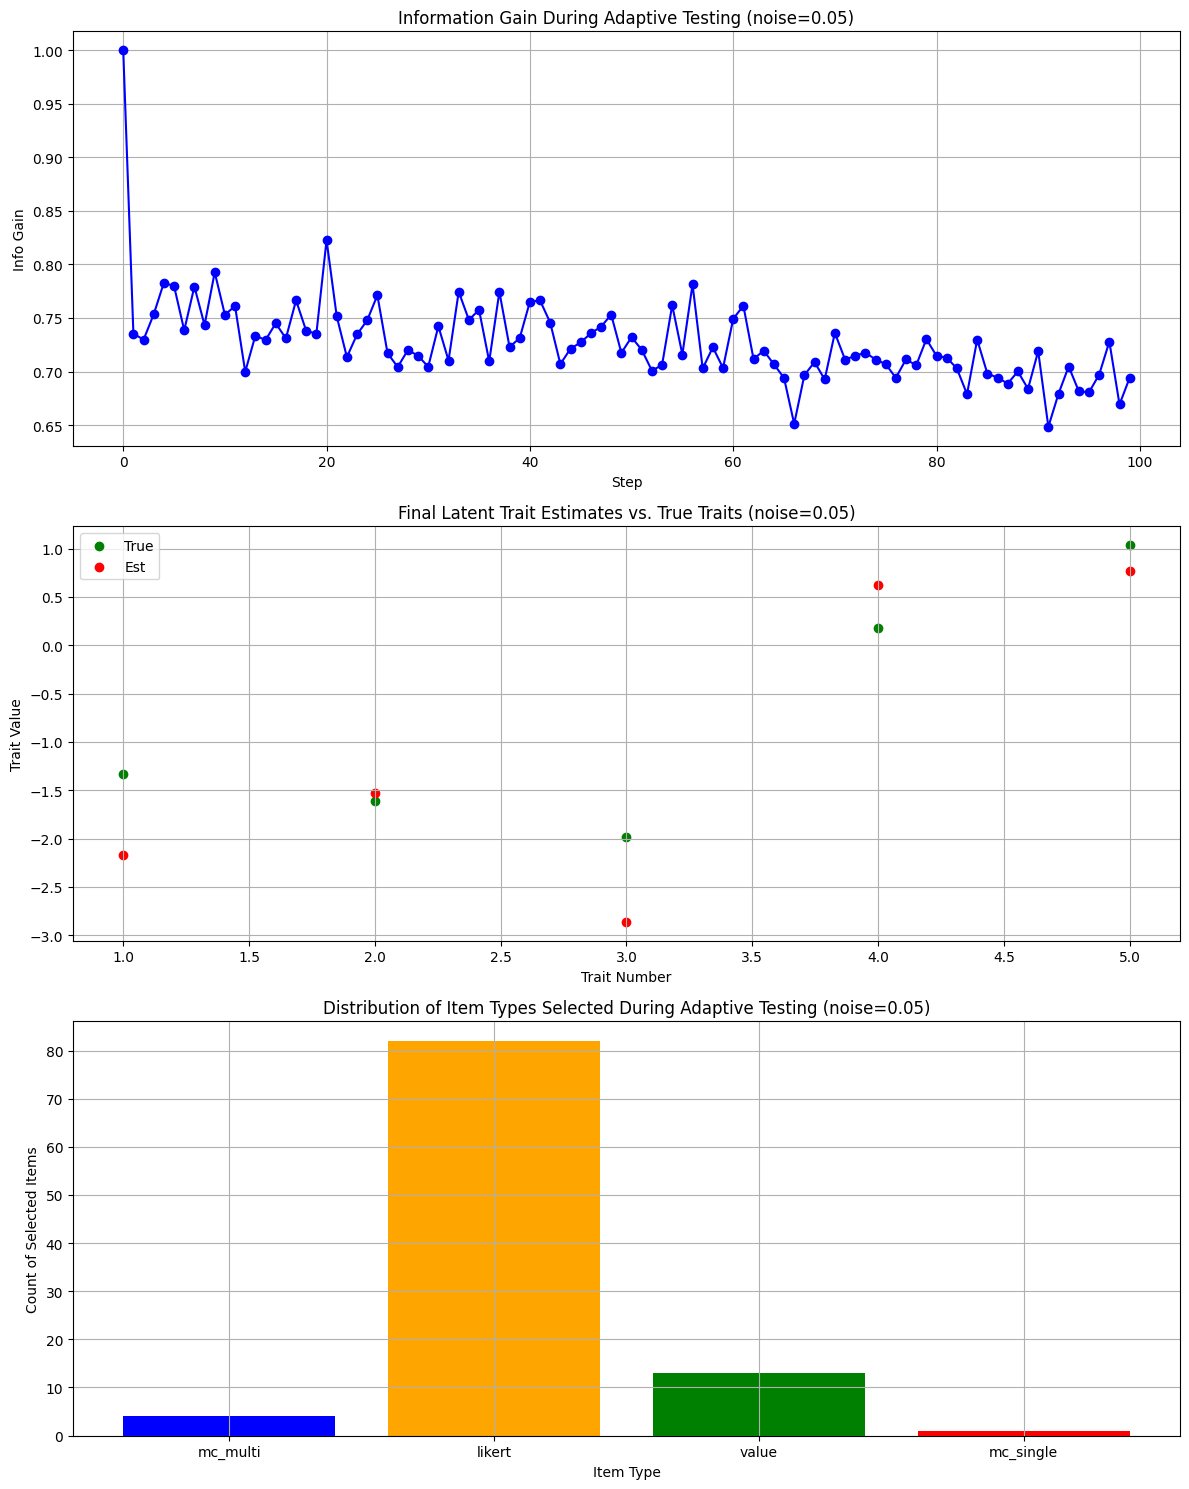

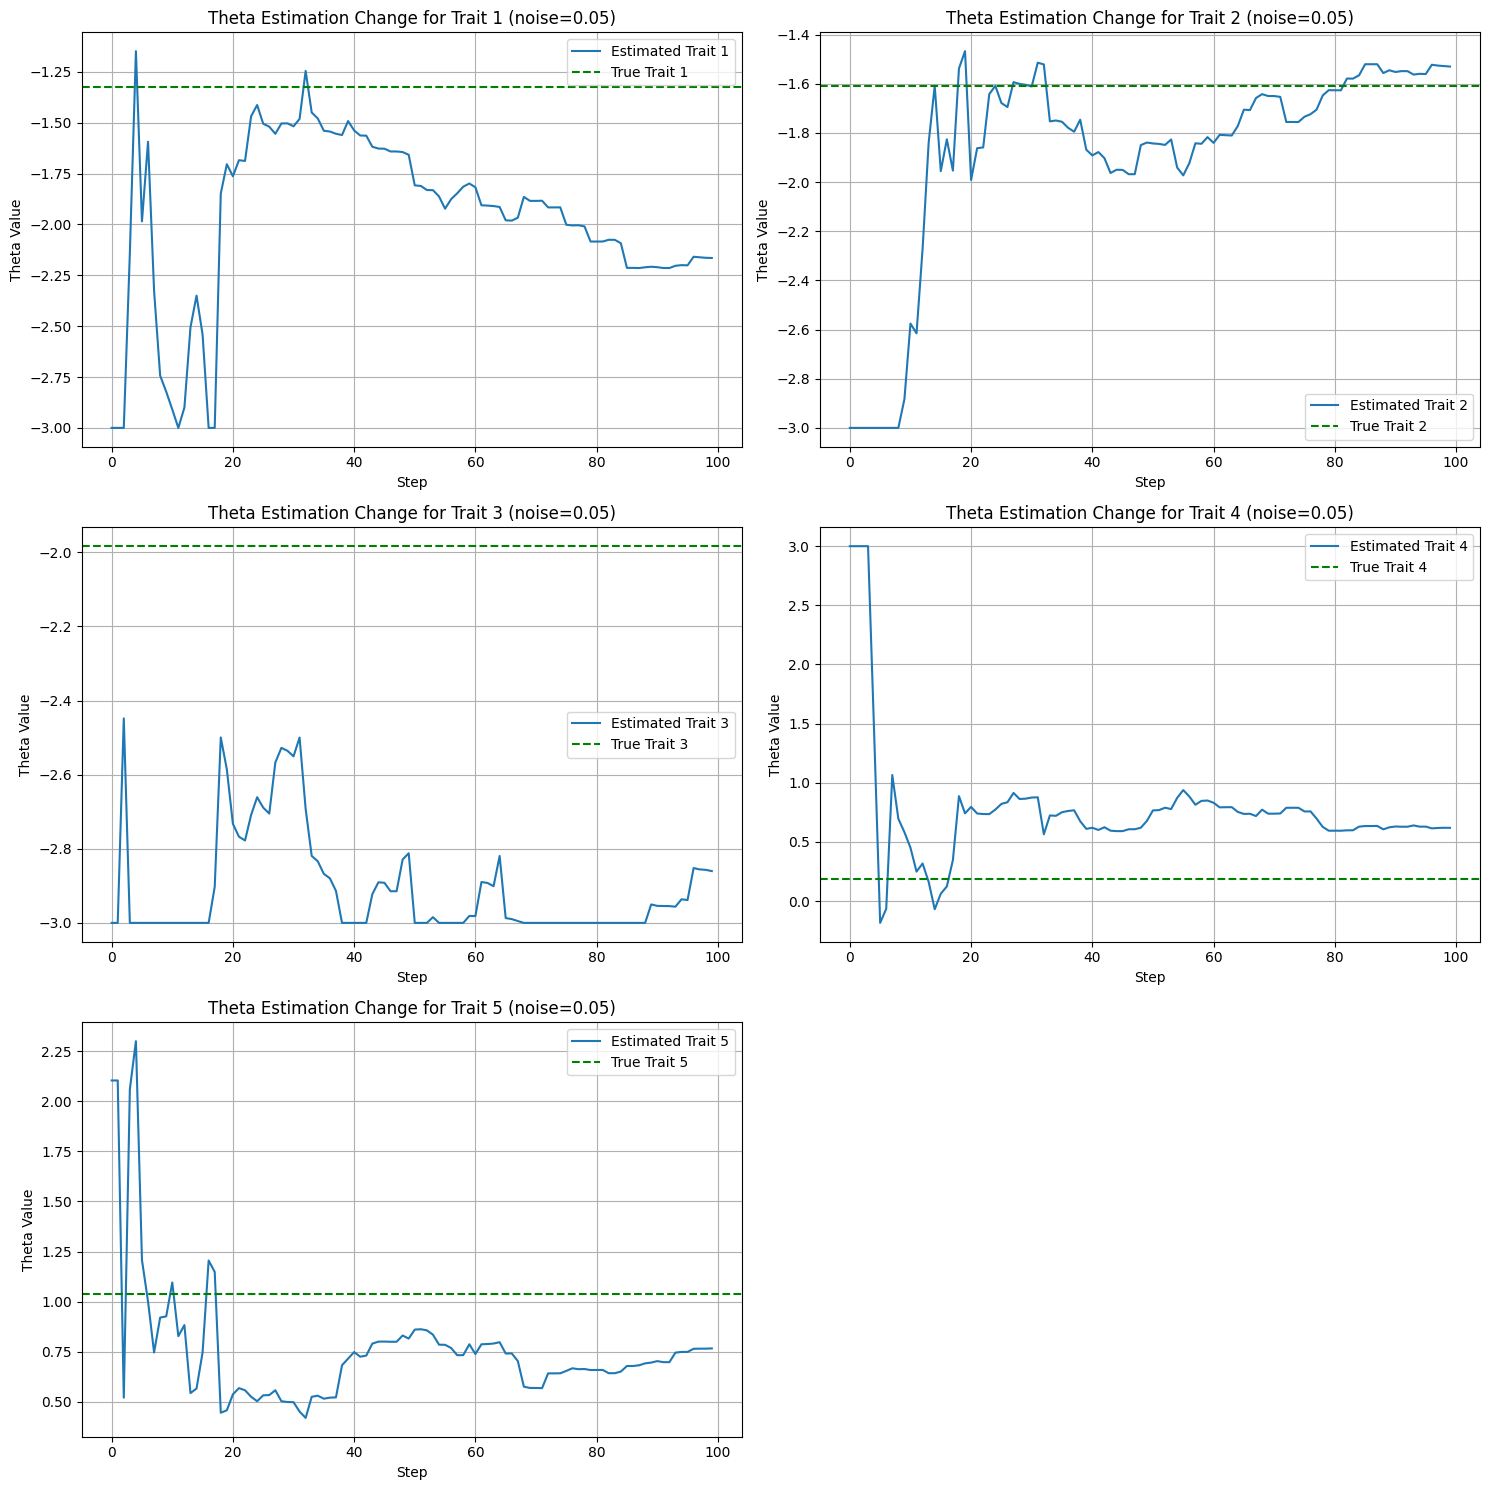

In [42]:
vanila.plot_results(save_fig=False)

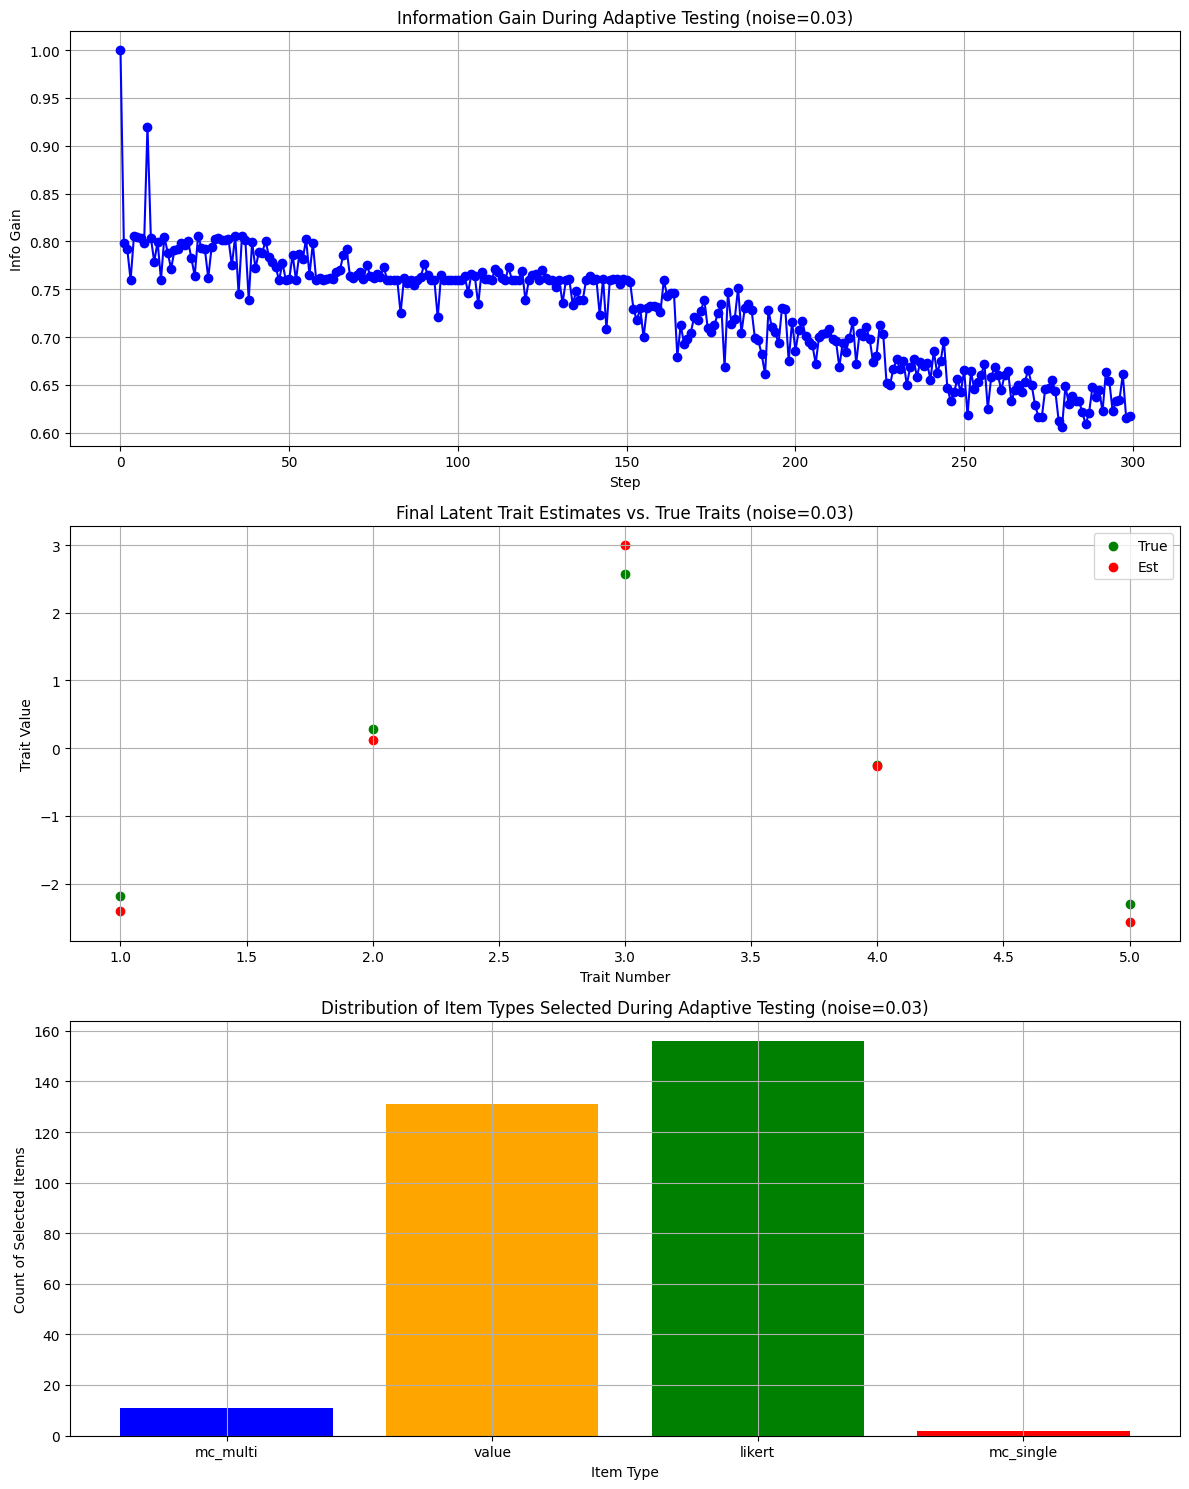

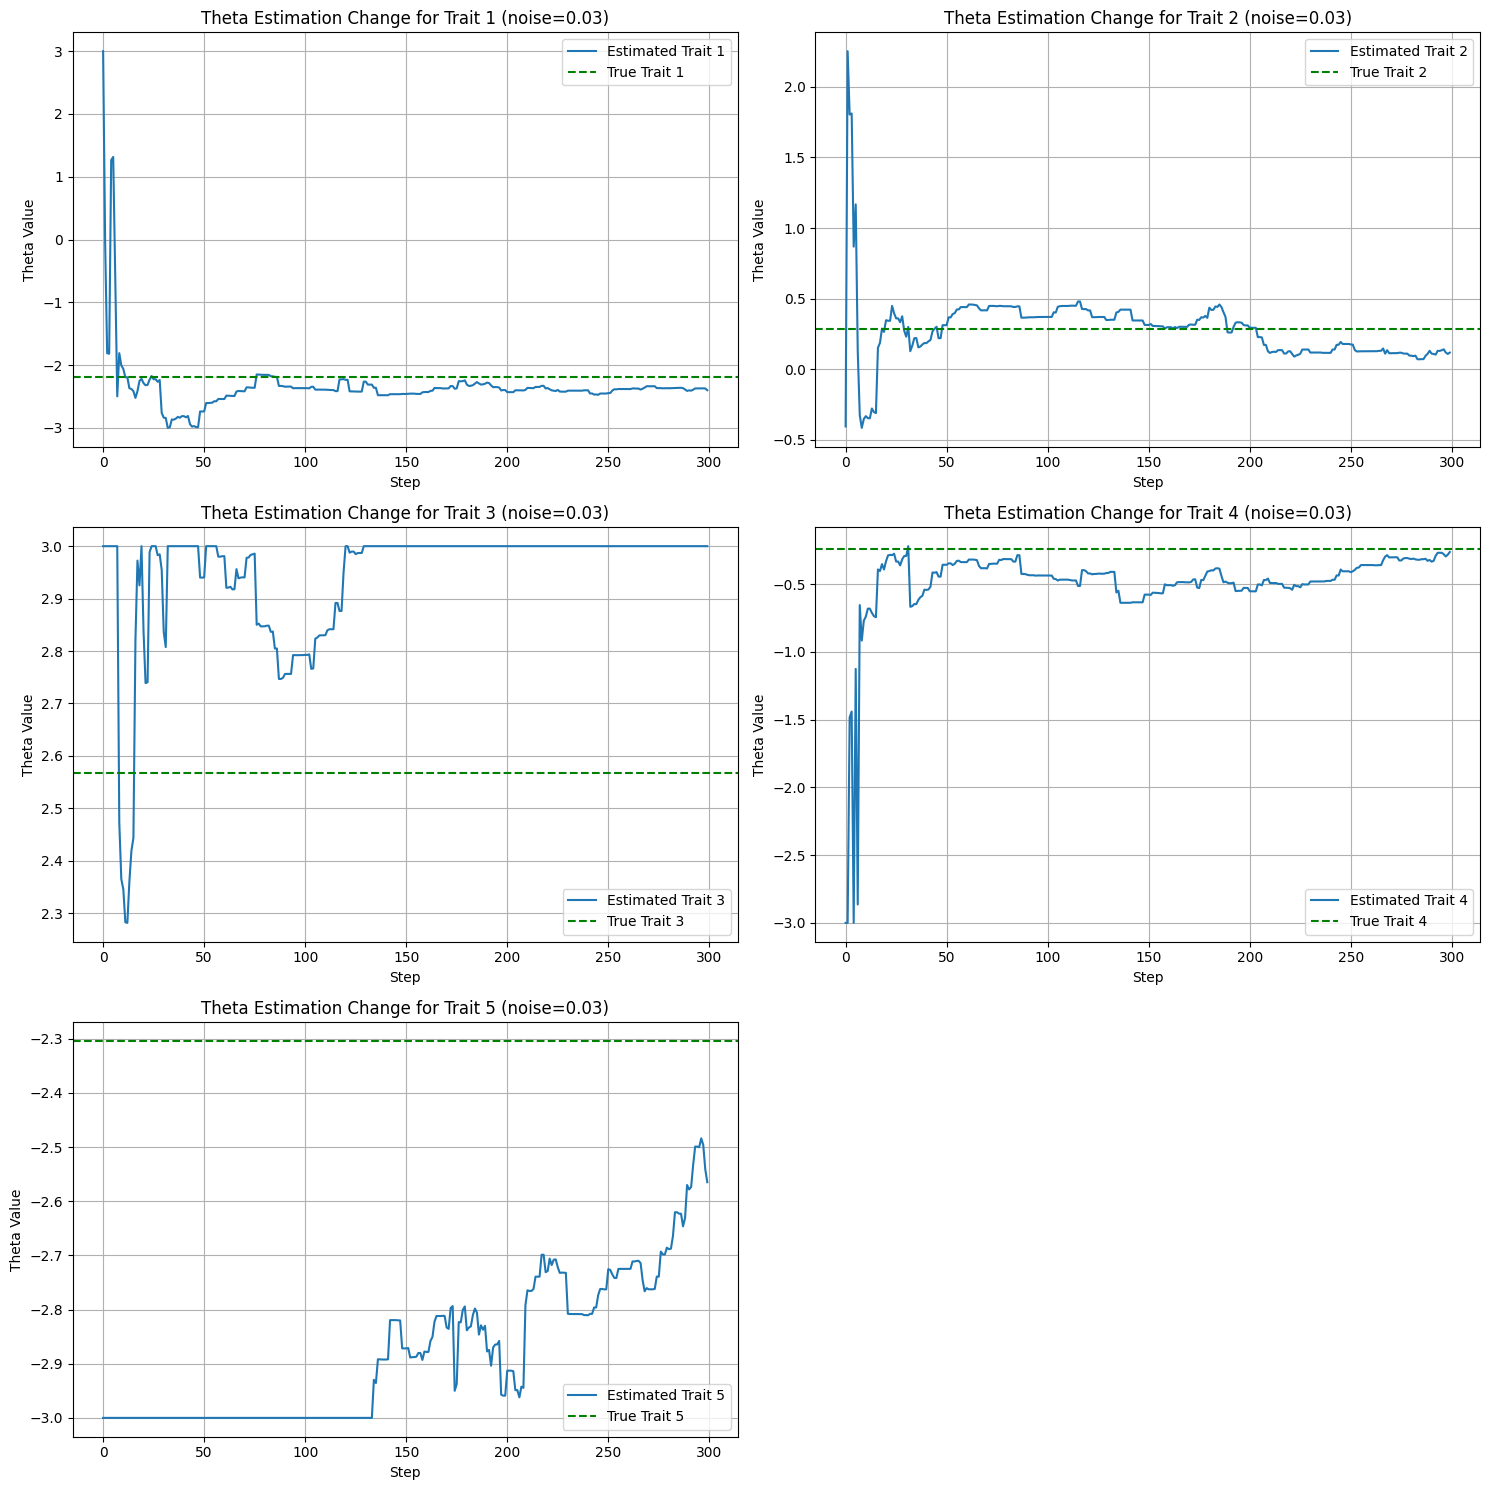

In [25]:
model.plot_results(save_fig=False)

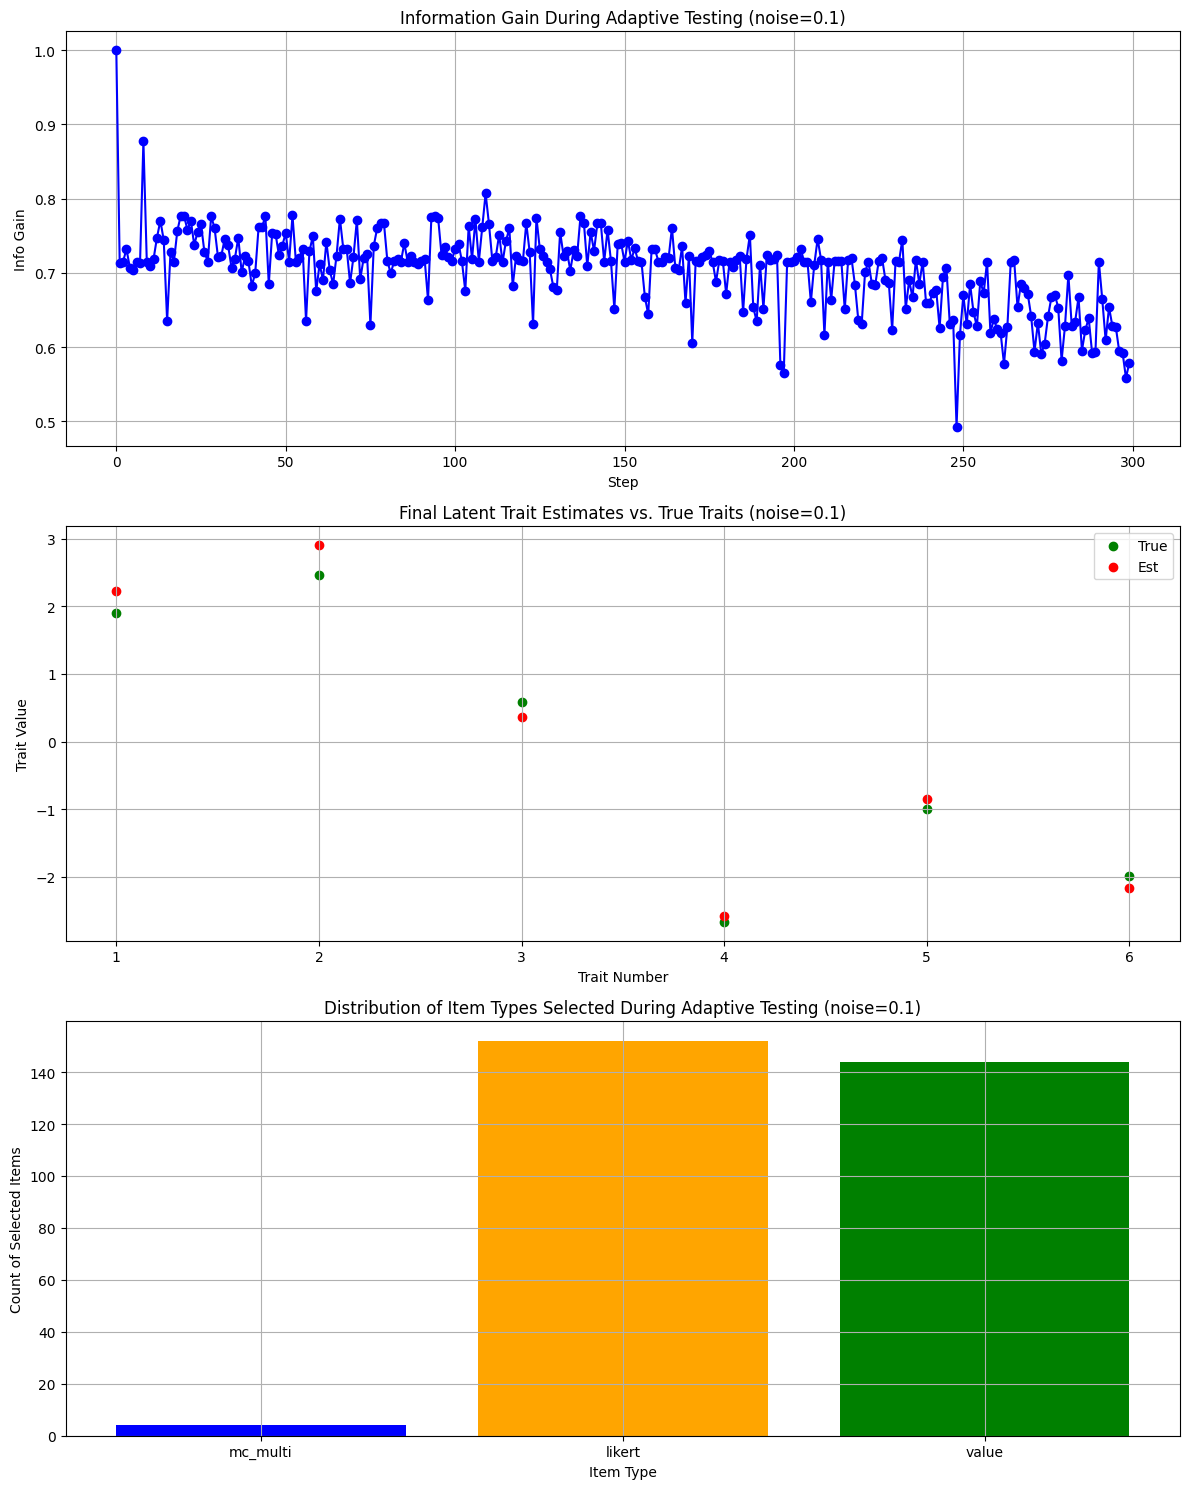

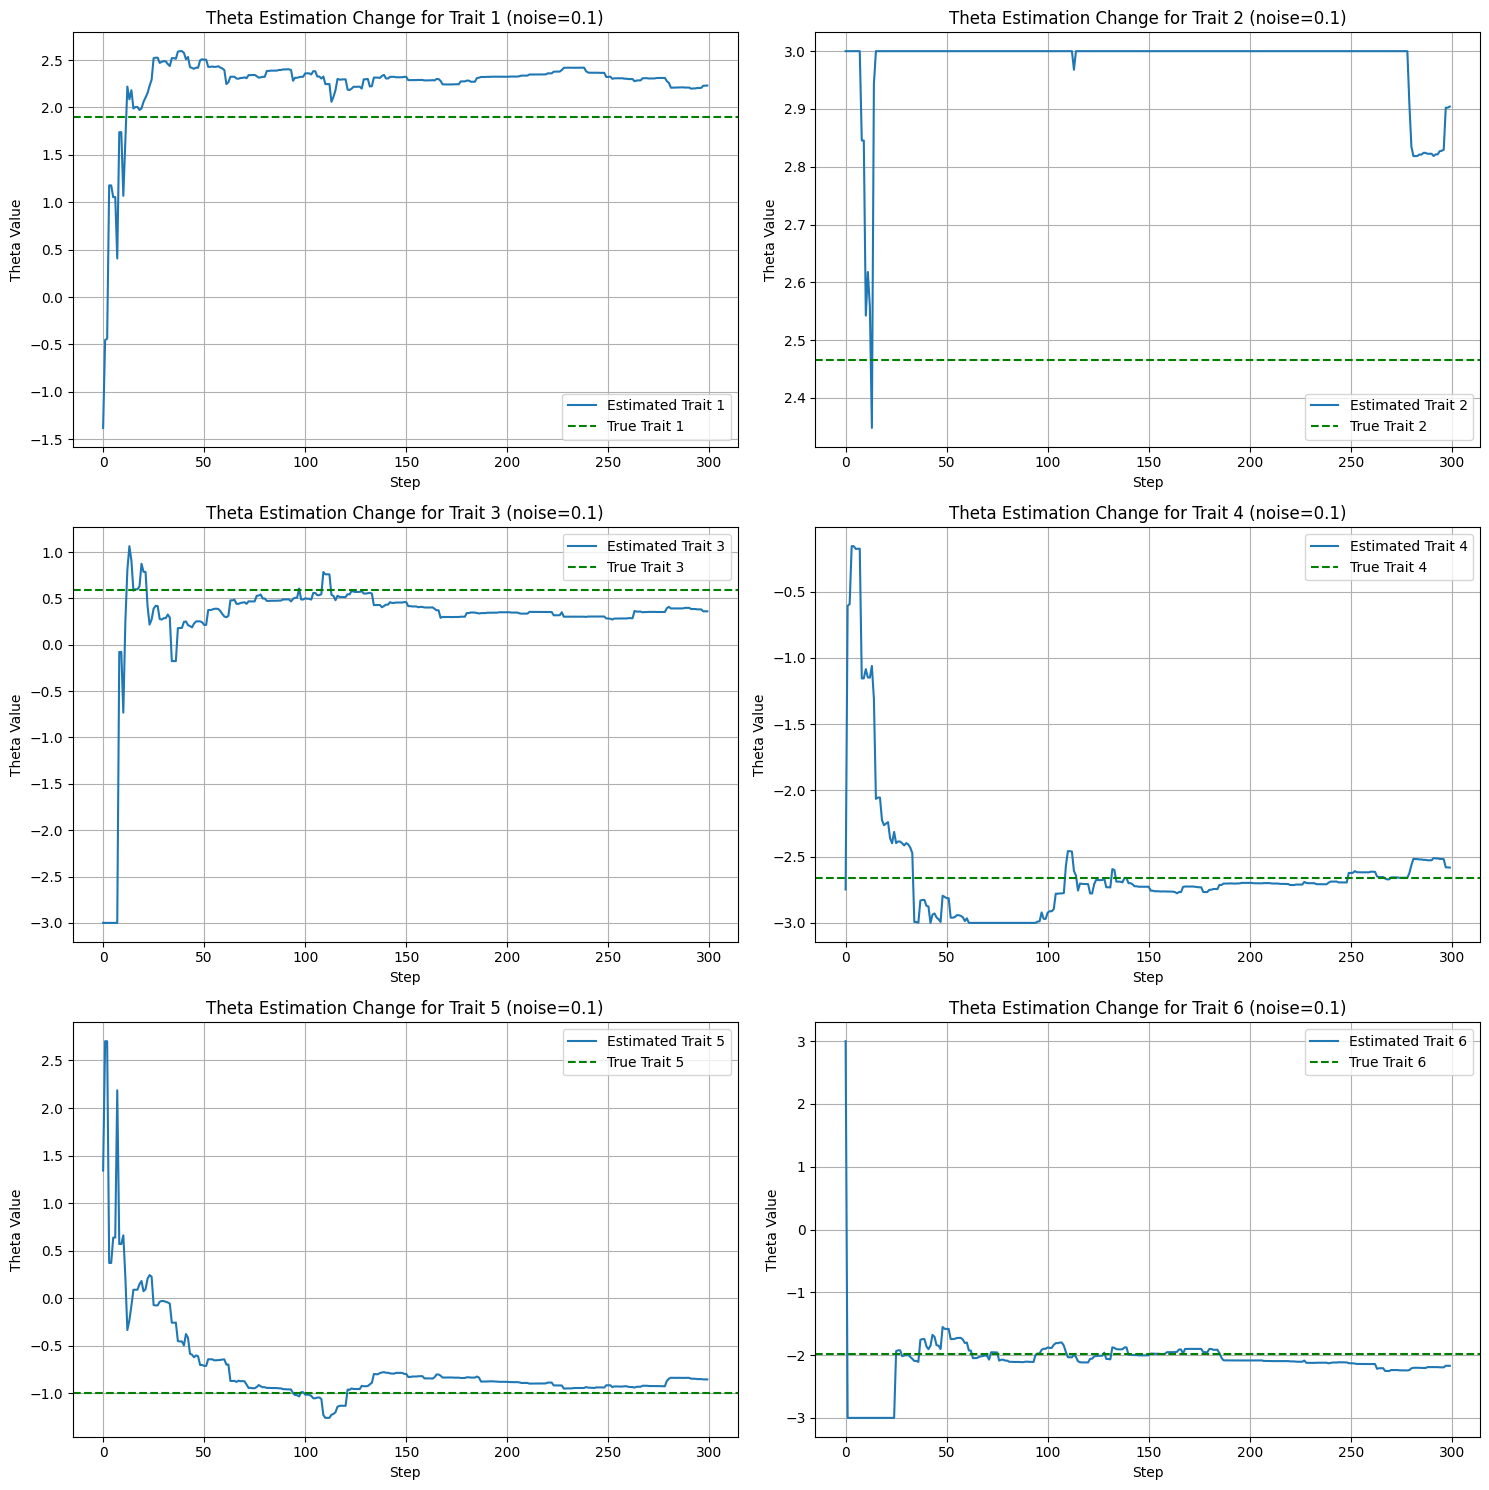

In [99]:
vanila.plot_results(save_fig=False)

In [21]:
import numpy as np

# Setup
n_items = 1000
probs = [0.4, 0.2, 0.2, 0.1, 0.1]
item_opts = ['likert', 'binary', 'value', 'mc_single', 'mc_multi']
item_types = np.random.choice(item_opts, size=n_items, p=probs)

# Subset of indices
x = np.random.randint(0, n_items, size=100)

# Dictionary to store the subset of x for each type
subset_x_by_type = {}

# Find the subset of x for each type


# Display the subset for each type
print("Subset of x by type:", subset_x_by_type)


Subset of x by type: {}


In [ ]:
# %%timeit
for item_type in item_opts:
    # Get indices in x where item_types is equal to item_type
    subset_x = x[item_types[x] == item_type]
    subset_x_by_type[item_type] = subset_x

In [ ]:
# %%timeit
subset_xs = [x[item_types[x] == item_opts[q]] for q in range(len(item_opts))]
subsex = [x[item_types[x] == item] for item in item_opts]

In [ ]:
subsex

In [ ]:
subset_xs

In [ ]:
subset_x_by_type

In [ ]:
import time
import numpy as np
from tqdm import tqdm
from model.IRT import AdaptiveMIRTv2

# Initialize AdaptiveMIRTv2 with test parameters
n_items = 1000    # Total number of items in the test pool
n_traits = 6      # Number of latent traits to estimate
n_steps = 100     # Number of adaptive testing steps
select_noise = 0.1  # Noise factor for item selection

# Instantiate the model
model = AdaptiveMIRTv2(select_noise=select_noise, n_items=n_items, n_traits=n_traits, verbose=False)

# Track timing for each adaptive step to observe performance improvements
iteration_times = []

# Run the adaptive testing loop
for step in tqdm(range(n_steps), desc="Running Optimized Adaptive Testing"):
    start_time = time.time()
    
    # Select the next item and simulate a response
    model.next_item()
    model.simulate_response()
    
    # Update theta estimates every 5 steps (for efficiency)
    if (step + 1) % 5 == 0:
        model.update_theta()
    
    # Record the elapsed time for this iteration
    iteration_times.append(time.time() - start_time)

# Plotting results using the class's plot_results method
model.plot_results(plot_info=True, plot_theta=True, no_show=False, save_fig=False)


Running Optimized Adaptive Testing:   3%|▎         | 3/100 [00:00<00:02, 35.22it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [2]:
model.responses

[1, 1, 1, array([0, 1, 0, 1])]

In [20]:
xxx = [x[model2.item_types[x]== item] for item in model.item_opts]

NameError: name 'x' is not defined

In [59]:
likerts = x[model.item_types[x]=='likert']

In [74]:
lpb = model.scale_prob(model.a_params[likerts], model.true_th, model.thresholds[likerts].T)

In [76]:
dff = model.a_params[likerts] @ model.true_th


ValueError: object too deep for desired array

In [92]:
resp = [np.argmax(np.random.multinomial(1,p))+1 for p in lpb.T]

In [100]:
lpb.T[resp].shape

(35,)

In [99]:
model.a_params.shape

(1000, 6)

In [26]:
selected = np.asarray(model.sel_items, dtype=int)

# Create subsets of selected items by type
xy = [selected[model.item_types[selected] == item_type] for item_type in model.item_opts]

In [54]:
pb = model.bin_prob(model.a_params[xy[1]],model.bin_b[xy[1]], model.est_th)

In [56]:
fg*np.log(pb+1e-8)+(1-fg)*np.log(1-pb+1e-8)

array([-1.85855968])

In [48]:
model.est_th[xy[1]] 

IndexError: index 885 is out of bounds for axis 0 with size 6

In [50]:
fg = np.array(model.responses)
fg

array([0])

In [39]:
aa = np.random.rand(1000, 6)  # Replace with your actual data

# Array of indices b (e.g., length 10)
bb = np.array([1, 5, 10, 50, 100, 150, 200, 250, 300, 350])

# Select rows of a based on indices in b
cc = aa[bb]

In [40]:
cc

array([[0.06143074, 0.2314039 , 0.24448349, 0.79507677, 0.58579589,
        0.14635856],
       [0.63706055, 0.95330077, 0.56318102, 0.99397019, 0.44116   ,
        0.07690867],
       [0.2033581 , 0.83755831, 0.25325864, 0.05751636, 0.77024365,
        0.22954901],
       [0.93613209, 0.6314675 , 0.52434157, 0.50763124, 0.7505899 ,
        0.97916401],
       [0.76042547, 0.32611368, 0.41111049, 0.41301441, 0.39822741,
        0.47535965],
       [0.99553957, 0.24506018, 0.70935715, 0.05362686, 0.84446481,
        0.01807199],
       [0.33153047, 0.68362539, 0.24957518, 0.63290601, 0.81251857,
        0.8151278 ],
       [0.15298281, 0.26776474, 0.26999244, 0.00124209, 0.12328494,
        0.84348917],
       [0.64709582, 0.36054719, 0.8021187 , 0.70426311, 0.53422537,
        0.77529375],
       [0.24784509, 0.42136373, 0.04306088, 0.79759435, 0.13230902,
        0.91863845]])

In [ ]:
a_params = np.random.randn(n_items, 6)
bin_b = np.random.randn(n_items)
theta0 = np.random.uniform(-3, 3, size=6)

In [ ]:
from scipy.special import expit
def bin_prob(a, b, theta):
    return expit(a @ theta - b)

In [ ]:
resp = np.random.binomial(1, prob_list)
resp

In [ ]:
%%timeit
probs = []
ll = 0
resps = []
for i in subset_xs[0]:
    prob = bin_prob(a_params[i], bin_b[i], theta0)
    prob = np.clip(prob, 1e-8, 1 - 1e-8)
    probs.append(prob)
    resp = np.random.binomial(1, prob)
    resps.append(resp)
    ll += resp * np.log(prob) + (1-resp) * np.log(1-prob)   

In [ ]:
%%timeit
p = np.clip(bin_prob(a_params[subset_xs[0]], bin_b[subset_xs[0]], theta0), 1e-8, 1 - 1e-8)
r = np.random.binomial(1, p)
nll = 0
nll = np.sum(r*np.log(p) + (1-r)*np.log(1-p))

In [ ]:
nll==ll

In [ ]:
%%timeit
prob_list = np.clip(bin_prob(a_params[subset_xs[0]], bin_b[subset_xs[0]], theta0), 1e-8, 1 - 1e-8)

In [ ]:
resp_list = 

In [ ]:
# Sampling from GAN latent space after training
with torch.no_grad():
    z = torch.randn(16, 20)  # Latent space dimension is 20
    gan_generated_images = generator(z).view(-1, 28, 28).numpy()
